# Lending Club Prediction Models

The following was inspired by a very good yhat blog post that created a prediction model for Lending Club loans using R:
http://blog.yhathq.com/posts/machine-learning-for-predicting-bad-loans.html

The point of this exercise was to translate the yhat post into Python as much as possible and use sci-kit learn to evaluate several Machine Learning models.

In [1]:
import pandas as pd
import graphlab as gl
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
pd.options.mode.chained_assignment = None 

sns.set(color_codes=True)

%matplotlib inline

[INFO] This non-commercial license of GraphLab Create is assigned to claus@calogica.comand will expire on September 21, 2016. For commercial licensing options, visit https://dato.com/buy/.

[INFO] Start server at: ipc:///tmp/graphlab_server-73118 - Server binary: /Users/claus/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1443397162.log
[INFO] GraphLab Server Version: 1.6.1


## Data Acquisition
Lending Club helpfully publishes anonymized loan data in csv format, which we'll use for this analysis.
You have to have a Lending Club log in to access the data, which is available here:
https://www.lendingclub.com/info/download-data.action

I've copied the files used in this analysis to a public Dropbox folder here:
https://dl.dropboxusercontent.com/u/12406727/Data/

To start, we'll load the files into a single pandas data frame:

In [21]:
# file_base_url = "https://dl.dropboxusercontent.com/u/12406727/Data/{0}"
file_base_url = "~/Dropbox/Public/Data/{0}"
column_type_hints = [int, int, int, int, int, str, str, str, str, str, str, str, str, int, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, str, int, int, int, str, int, str, float, float, float, float, float, float, float, float, float, str, float, str, str, int, int, int, str, int]
a = gl.SFrame.read_csv(file_base_url.format("LoanStats3a_securev1.csv"), skiprows=1, column_type_hints = column_type_hints)
b = a.append(gl.SFrame.read_csv(file_base_url.format("LoanStats3b_securev1.csv"), skiprows=1, column_type_hints=column_type_hints))
c = b.append(gl.SFrame.read_csv(file_base_url.format("LoanStats3c_securev1.csv"), skiprows=1, column_type_hints=column_type_hints))
d = c.append(gl.SFrame.read_csv(file_base_url.format("LoanStats3d_securev1.csv"), skiprows=1, column_type_hints=column_type_hints))
                    
# a = pd.read_csv(file_base_url.format("LoanStats3a_securev1.csv"), index_col='id', header=1, parse_dates=['issue_d'])
# b = pd.read_csv(file_base_url.format("LoanStats3b_securev1.csv"), index_col='id', header=1, parse_dates=['issue_d'])
# c = pd.read_csv(file_base_url.format("LoanStats3c_securev1.csv"), index_col='id', header=1, parse_dates=['issue_d'])
# d = pd.read_csv(file_base_url.format("LoanStats3d_securev1.csv"), index_col='id', header=1, parse_dates=['issue_d'])

# frames = [a,b,c,d]
# df = pd.concat(frames)

PROGRESS: Unable to parse line ""131387","113921","6000","6000","600"," 36 months"," 10.59%","195.27","C","C2","Columbia University","2 years","RENT","19000","not verified","Oct-2007","Fully Paid","n","https://www.lendingclub.com/browse/loanDetail.action?loan_id=131387","I'm currently a ..."
PROGRESS: Unable to parse line ""127213","85483","2000","2000","1575"," 36 months","  7.12%","61.87","A","A1","U.S. Government","10+ years","MORTGAGE","118000","not verified","Sep-2007","Fully Paid","n","https://www.lendingclub.com/browse/loanDetail.action?loan_id=127213","consolidate de..."
PROGRESS: Unable to parse line ""84918","84914","5000","5000","2025"," 36 months","  7.43%","155.38","A","A2","Revere Public Schools","10+ years","MORTGAGE","65000","not verified","Sep-2007","Fully Paid","n","https://www.lendingclub.com/browse/loanDetail.action?loan_id=84918","I'd like t..."
PROGRESS: Unable to parse line ""121568","121574","4000","4000","1925"," 36 months","  9.64%","128.41","B","B4","","< 1 y

In [23]:
print 'Records:', len(d)
# df.describe()

Records: 550419


## Data Prep & Cleanup
We'll need to do a bit of data cleanup and we'll follow the yhat post pretty closely here.

In [24]:
del d['desc']
del d['mths_since_last_record']

### Drop columns with more than 80% NA values
This also drops any totals columns that might have snuck in.

In [29]:
data = d #[d['member_id'] > 0].dropna(axis=1,thresh=len(d['member_id'])*.80)

In [42]:
data.show()

Canvas is accessible via web browser at the URL: http://localhost:50602/index.html
Opening Canvas in default web browser.


### Tag bad loans

In [38]:
bad_indicators = ['Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Charged Off']

In [41]:
# set is_bad indicator to true to loans in status with 'bad' indicators
data['is_bad'] = data.apply(lambda x: x['loan_status'] in bad_indicators)
# data[data.filter_by(bad_indicators, 'loan_status')]['is_bad'] = True
data['is_bad']
# data.loc[data['loan_status'].isin(bad_indicators), 'is_bad'] = True
# data.loc[data['loan_status'] =="", 'is_bad'] = np.nan

dtype: int
Rows: 550419
[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ... ]

In [43]:
# how many bad loans?
print 'Total loans:\t', len(data)
print 'Bad loans:\t', len(data[data['is_bad']==True])
print 'Bad loan %:\t', len(data[data['is_bad']==True])*1./len(data)*1.

Total loans:	550419
Bad loans:	35369
Bad loan %:	0.0642583195711


## Data Type Cleanup

In [19]:
def convert_date(x):
    try:
        return pd.datetime.strptime(x, '%b-%Y')
    except:
        print x
        raise
        
# sometimes this necessary, sometimes not...probably depends on version of pandas installed
# dateparse = lambda x: convert_date(x)
# data.loc[:,'issue_d'] = data.issue_d.map(dateparse)

### Dates

In [44]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
# data.loc[:,'year_issued'] = data.issue_d.dt.year
# data.loc[:,'month_issued'] = data.issue_d.dt.month
# data.loc[:,'earliest_cr_line'] = pd.to_datetime(data.earliest_cr_line)
# data.loc[:,'revol_util'] = data['revol_util'].str.replace("[%]", "").astype(float)
# data.loc[:,'revol_util'] = data['revol_util'].astype(float)

TypeError: data type not understood

### Categorical Features

In [ ]:
data.home_ownership = data.home_ownership.astype('category')
data.loc[:,'is_rent'] = False
data.loc[data['home_ownership'].isin(['RENT']), 'is_rent'] = True
data.loc[:,'fico_range'] = data.fico_range_high.astype('category')
data.loc[:,'fico_ordered'] = data.fico_range_high.astype('float')

In [22]:
feature_cols = ['is_bad', 'loan_amnt', 'annual_inc', 'fico_range_low', 'fico_range_high', 
                'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 
                'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
                'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 
                'last_fico_range_high', 'last_fico_range_low',
                'is_rent']

### Scaling

In [23]:
# # get numeric columns only, _get_numeric_data is private
numeric_cols = [c for c in data._get_numeric_data().columns if not c == 'is_bad']
d_feat = data[feature_cols].fillna(0)

In [29]:
d_feat;

### Scale numeric columns
We'll scale all numeric columns by adjusting them by their means and standard deviations.

In [27]:
for c in d_feat.columns:
    if c in numeric_cols: 
        d_feat.loc[:,c] = (d_feat[c]-d_feat[c].mean())/d_feat[c].std()


### Get only mature loans to make sure they had enough to be paid off 

In [32]:
data_2012 = d_feat[data['year_issued'] <= 2012]

In [33]:
print 'Total loans:\t', len(data_2012.index)
print 'Bad loans:\t', len(data_2012[data_2012['is_bad']==True])
print 'Bad loan %:\t', len(data_2012[data_2012['is_bad']==True])*1./len(data_2012)*1.

Total loans:	95902
Bad loans:	13386
Bad loan %:	0.139579987904


## Prediction Modeling
We'll use sci-kit learn for all models, to create a model designed to predict whether a loan will be 'bad'. 

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_curve, auc

from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [36]:
cols = [c for c in feature_cols if c != 'is_bad']
X = data_2012[cols]
y = data_2012.is_bad

A few helper functions:

In [37]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Bad', 'Good'], rotation=45)
    plt.yticks(tick_marks, ['Bad', 'Good'])
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_roc(actual, predictions):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)

    roc_auc = auc(false_positive_rate, true_positive_rate)
    print "thresholds:", thresholds
    print "AUC:", roc_auc
    
    plt.figure(figsize=(12,9))
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_histogram(data, bins=50):
    f = plt.figure(figsize=(12,9))
    plt.title('Histogram')
    ax = f.add_subplot(111)
    ax.hist(data, bins=bins)
    plt.show()
    

In [38]:
def run_prediction(X, y, model):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    print '----------------------------'
    print 'X_train\t',X_train.shape
    print 'X_test\t',X_test.shape
    print 'y_train\t',y_train.shape
    print 'y_test\t',y_test.shape
    print '----------------------------'
    
    print '\n'
    print '-----------------------------------------'
    print 'Running model with train/test split...'
    print '-----------------------------------------'

    X_train_feat = X_train[cols].fillna(0)
    #fit on training data
    model.fit(X_train, y_train)

# uncomment to print out the coefficients

#     if hasattr(model, 'coef_'):
#         print '\n'
#         print 'Coefficients for each X:\n'
#         coeff = zip(cols, model.coef_[0])
#         for c, e in coeff:
#             print c, '\t', e
    X_test_feat = X_test[cols].fillna(0)

#     y_pred = None
#     if hasattr(model, 'predict_proba'):
#         y_pred = model.predict_proba(X_test_feat)
#     else:
    y_pred = model.predict(X_test_feat)
    
    y_score = None
    if hasattr(model, 'decision_function'):
        y_score = model.fit(X_train, y_train).decision_function(X_test_feat)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print "Accuracy of model:\t", accuracy #(y_test == y_pred).mean()
  
    data_split = { 'X_train': X_train_feat, 
                'X_test': X_test_feat, 
                'y_train': y_train, 
                'y_test': y_test, 
                'y_pred': y_pred
           }
    return model, data_split, y_score

def confusion_matrix(y_test, y_pred):
#     print 'Confusion Matrix\n', 
    cm = metrics.confusion_matrix(y_test, y_pred)
#     print cm
    
    np.set_printoptions(precision=3)
#     print '\n'
#     print 'Confusion matrix, without normalization\n'
#     plt.figure()
#     plot_confusion_matrix(cm)
#     plt.show()
    
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print '\nNormalized confusion matrix'
    print(cm_normalized)
    
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

    return cm 

def model_metrics(model, X, y, data_split):
    
    print '-----------------------------------------'
    print 'Metrics:'
    print '-----------------------------------------'
    y_test = data_split['y_test']
    y_pred = data_split['y_pred']
    
    X_train = data_split['X_train']
    X_test = data_split['X_test']
    y_train = data_split['y_train']
    
    print 'MSE\t', metrics.mean_squared_error(y_test, y_pred)
    print 'RMSE\t', np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    score_general = model.score(X[cols].fillna(0), y)
    
    print '\n'
    print '-----------------------------------------'
    print 'Scores:'
    print '-----------------------------------------'
    print 'Train\t', score_train
    print 'Test\t', score_test
    print 'General\t', score_general
    print '-----------------------------------------\n'

    return score_test, score_general

def cross_validation(model, X, y, n_jobs=1):
    
    print '-----------------------------------------'
    print 'Running model using Cross Validation:'
    print '-----------------------------------------'

    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=n_jobs, verbose=1)
    score_cross_val_mean = scores.mean()
    print 'Mean Cross-Val Score:', score_cross_val_mean

    return scores

### Let's try some basic logistic regression first

----------------------------
X_train	(71926, 22)
X_test	(23976, 22)
y_train	(71926,)
y_test	(23976,)
----------------------------


-----------------------------------------
Running model with train/test split...
-----------------------------------------
Accuracy of model:	0.9752669336

Normalized confusion matrix
[[ 0.991  0.009]
 [ 0.12   0.88 ]]


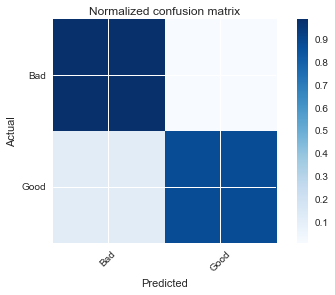

-----------------------------------------
Metrics:
-----------------------------------------
MSE	0.0247330663997
RMSE	0.157267499502



[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished



-----------------------------------------
Scores:
-----------------------------------------
Train	0.974195701137
Test	0.9752669336
General	0.974463514838
-----------------------------------------

-----------------------------------------
Running model using Cross Validation:
-----------------------------------------
Mean Cross-Val Score: 0.969918163688
CPU times: user 18.4 s, sys: 539 ms, total: 18.9 s
Wall time: 19.9 s


In [39]:
%%time

from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C=1e5)
log, log_data_split, log_y_score = run_prediction(X, y, log)
log_y_test = log_data_split['y_test']
log_y_pred = log_data_split['y_pred']

confusion_matrix(log_y_test, log_y_pred)

model_metrics(log, X, y, log_data_split)

scores = cross_validation(log, X, y, n_jobs=1)

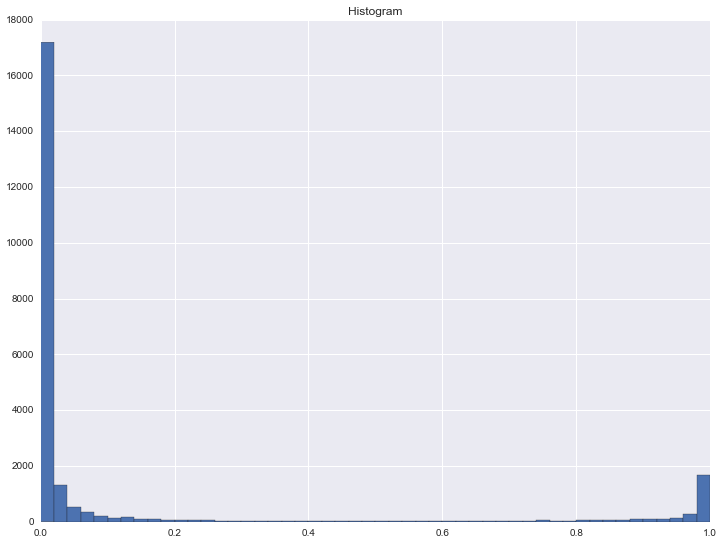

In [40]:
p = log.predict_proba(log_data_split['X_test'])
plot_histogram(p[:,1])

thresholds: [ 82.288  72.942  62.584 ..., -28.589 -34.631 -35.318]
AUC: 0.99051901745


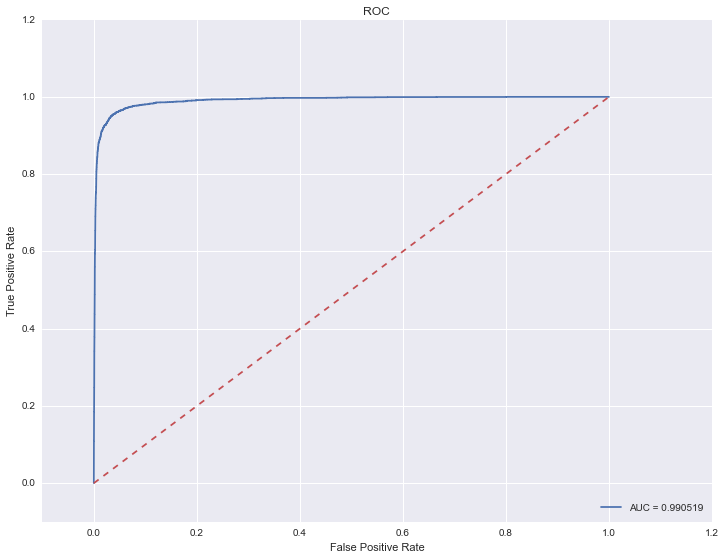

In [41]:
plot_roc(log_data_split['y_test'], log_y_score)

### K Neighbors

----------------------------
X_train	(71926, 22)
X_test	(23976, 22)
y_train	(71926,)
y_test	(23976,)
----------------------------


-----------------------------------------
Running model with train/test split...
-----------------------------------------
Accuracy of model:	0.964547881215

Normalized confusion matrix
[[ 0.987  0.013]
 [ 0.169  0.831]]


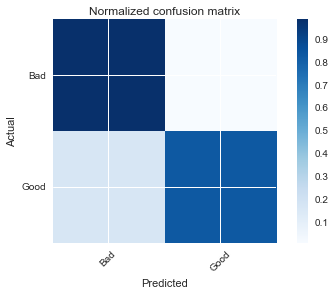

In [ ]:
%%time

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn, knn_data_split, knn_y_score = run_prediction(X, y, knn)

knn_y_test = knn_data_split['y_test']
knn_y_pred = knn_data_split['y_pred']

confusion_matrix(knn_y_test, knn_y_pred)

model_metrics(knn, X, y, knn_data_split)
# scores = cross_validation(knn, X, y, n_jobs=5)

In [ ]:
p = knn.predict_proba(knn_data_split['X_test'])
plot_histogram(p[:,1])

#### Using GridSearch to test n_neighbors parameters

In [ ]:
# %%time
# from sklearn.grid_search import GridSearchCV

# n_range = range(1,11)
# param_grid = dict(
#               n_neighbors=n_range
#              )
# knn = KNeighborsClassifier()

# grid = GridSearchCV(knn, param_grid, scoring='accuracy', n_jobs = 1)
# grid.fit(X, y);

In [ ]:
plot_roc(knn_data_split['y_test'], knn_y_score)

In [ ]:
# grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
# print grid_mean_scores
# print 'best params', grid.best_params_
# print 'best params', grid.best_estimator_
# print 'best params', grid.best_score_

In [ ]:
# plt.plot(n_range, score grid.grid_scores_)
# plt.xlabel('Value of N for n_neighbors')
# plt.ylabel('Cross-Validated Accuracy')

### Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------------
X_train	(71926, 22)
X_test	(23976, 22)
y_train	(71926,)
y_test	(23976,)
----------------------------


-----------------------------------------
Running model with train/test split...
-----------------------------------------
Accuracy of model:	0.98469302636

Normalized confusion matrix
[[ 0.997  0.003]
 [ 0.093  0.907]]


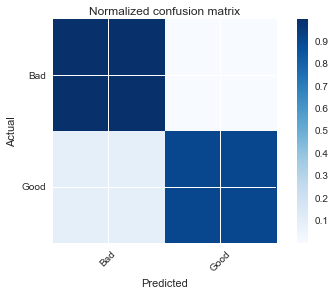

-----------------------------------------
Metrics:
-----------------------------------------
MSE	0.0153069736403
RMSE	0.123721354827


-----------------------------------------
Scores:
-----------------------------------------
Train	0.974265217029
Test	0.974891558225
General	0.974421805593
-----------------------------------------

-----------------------------------------
Running model using Cross Validation:
-----------------------------------------


[Parallel(n_jobs=5)]: Done   1 jobs       | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done   2 out of  10 | elapsed:    3.3s remaining:   13.2s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    7.2s finished


Mean Cross-Val Score: 0.976633120361
CPU times: user 3.84 s, sys: 635 ms, total: 4.47 s
Wall time: 8.77 s


In [77]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=5)
print rf

rf, rf_data_split, rf_y_score = run_prediction(X, y, rf)

rf_y_test = rf_data_split['y_test']
rf_y_pred = rf_data_split['y_pred']

confusion_matrix(rf_y_test, rf_y_pred)

model_metrics(log, X, y, rf_data_split)

scores = cross_validation(rf, X, y, n_jobs=5)

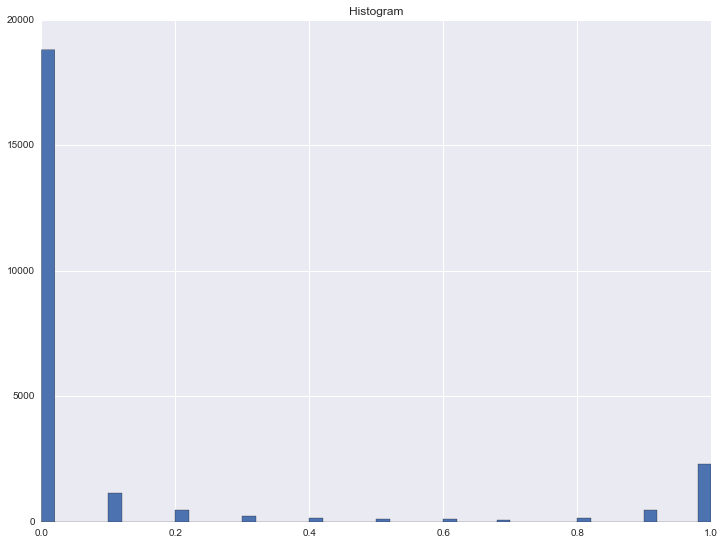

In [78]:
# 0.977352599188
p = rf.predict_proba(rf_data_split['X_test'])
plot_histogram(p[:,1])

In [79]:
# plot_roc(rf_data_split['y_test'], rf_y_score)
print pd.DataFrame(zip(cols, rf.feature_importances_)).sort(1, ascending=False)

                          0         1
20      last_fico_range_low  0.258810
16               recoveries  0.236132
17  collection_recovery_fee  0.086920
13          total_rec_prncp  0.077512
19     last_fico_range_high  0.062985
18          last_pymnt_amnt  0.048224
0                 loan_amnt  0.036254
11              total_pymnt  0.027786
4            inq_last_6mths  0.025050
12          total_pymnt_inv  0.024922
14            total_rec_int  0.018378
9                 out_prncp  0.016707
7                 revol_bal  0.013428
10            out_prncp_inv  0.012818
2            fico_range_low  0.011668
3           fico_range_high  0.011594
8                 total_acc  0.009820
1                annual_inc  0.008224
5                  open_acc  0.006390
15       total_rec_late_fee  0.004371
21                  is_rent  0.001284
6                   pub_rec  0.000725


In [80]:
data.groupby("is_bad")["recoveries"].sum()

is_bad
0      368730.517530
1    17017697.235434
Name: recoveries, dtype: float64

###Gradient Boosted Regression Tree

----------------------------
X_train	(71926, 22)
X_test	(23976, 22)
y_train	(71926,)
y_test	(23976,)
----------------------------


-----------------------------------------
Running model with train/test split...
-----------------------------------------
Accuracy of model:	0.988321654988

Normalized confusion matrix
[[ 0.998  0.002]
 [ 0.068  0.932]]


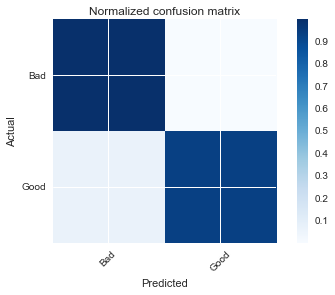

-----------------------------------------
Metrics:
-----------------------------------------
MSE	0.0116783450117
RMSE	0.108066391684


-----------------------------------------
Scores:
-----------------------------------------
Train	0.974195701137
Test	0.9751001001
General	0.974421805593
-----------------------------------------

CPU times: user 18min 54s, sys: 3.61 s, total: 18min 58s
Wall time: 19min


In [89]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=3000, max_features=1.0, learning_rate=0.01, 
                                    max_depth=4, min_samples_leaf=5)

gb, data_split, y_score = run_prediction(X, y, gb)

y_test = data_split['y_test']
y_pred = data_split['y_pred']

confusion_matrix(y_test, y_pred)

model_metrics(log, X, y, data_split)
# scores = cross_validation(log, X, y, n_jobs=5)

In [90]:
print pd.DataFrame(zip(cols, gb.feature_importances_)).sort(1, ascending=False)

                          0         1
0                 loan_amnt  0.104411
9                 out_prncp  0.094701
13          total_rec_prncp  0.094135
10            out_prncp_inv  0.090610
19     last_fico_range_high  0.088747
20      last_fico_range_low  0.088033
16               recoveries  0.076464
18          last_pymnt_amnt  0.061913
11              total_pymnt  0.043652
7                 revol_bal  0.039477
15       total_rec_late_fee  0.034753
14            total_rec_int  0.033473
12          total_pymnt_inv  0.027701
1                annual_inc  0.026279
8                 total_acc  0.018598
4            inq_last_6mths  0.018503
5                  open_acc  0.016361
3           fico_range_high  0.015355
2            fico_range_low  0.015141
17  collection_recovery_fee  0.010902
21                  is_rent  0.000667
6                   pub_rec  0.000124


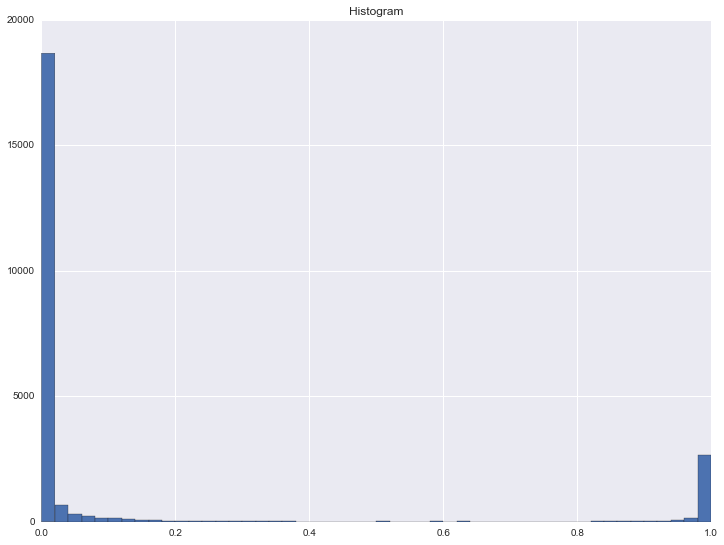

In [91]:
p = gb.predict_proba(data_split['X_test'])
plot_histogram(p[:,1])

##ROC Curves

thresholds: [ 11.705  11.415  10.688 ..., -10.968 -11.129 -11.483]
AUC: 0.996244845284


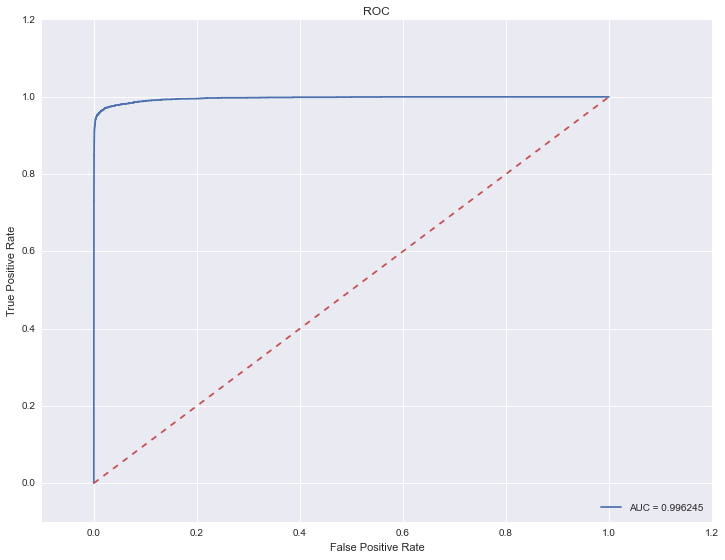

In [92]:
plot_roc(data_split['y_test'], y_score)

##Selecting Hyperparameters With Cross Validation


In [ ]:
from sklearn.grid_search import GridSearchCV

# est_range = [100, 150, 200]
# depth_range = range(1,6)
# n_scores = []
param_grid = dict(
              learning_rate=[0.1, 0.05, 0.02, 0.01],
              max_depth=[4, 6],
              min_samples_leaf=[3, 5, 9, 17],
              max_features=[1.0, 0.3, 0.1]
             )
gb = GradientBoostingClassifier(n_estimators=3000)

grid = GridSearchCV(gb, param_grid, scoring='accuracy', n_jobs = 4)
grid.fit(X, y)

In [ ]:
print 'best params', grid.best_params_
print 'best params', grid.best_estimator_
print 'best params', grid.best_score_

In [ ]:
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
print grid_mean_scores

In [ ]:
# r = pd.DataFrame(grid.grid_scores_)

In [ ]:
# res = zip([x['n_estimators'] for x in r[0]], [x['max_depth'] for x in r[0]], [x for x in r[1]])

In [ ]:
# dr = pd.DataFrame(res)
# dr;

In [ ]:
# # plot the results
# est_score = dr.groupby(dr[0]).mean()
# print est_score

# plt.plot(est_range, est_score[2])
# plt.xlabel('Value of N for n_estimators')
# plt.ylabel('Cross-Validated Accuracy')
# plt.ylim(dr[2].min(), dr[2].max())

In [ ]:
# plot the results
md_score = dr.groupby(dr[1]).mean()
print md_score
plt.plot(depth_range, md_score[2])
plt.xlabel('Value of N for max_depth')
plt.ylabel('Cross-Validated Accuracy')
plt.ylim(dr[2].min(), dr[2].max())

In [ ]:
(md_score[2]-md_score[2].mean())/(md_score[2].xmax()-est_score[2].min())